# Proyecto Optimización - Mejora Proceso Tulas

---
## Maestría en Inteligencia Analítica para la Toma de Decisiones


* **Profesor**:
    * *Andrés Medaglia*
* **Grupo 6**:
    * *Angelica Ruce*
    * *David Moreno*
    * *Nicolas Cruz*
    * *Santiago Romero*

## Formulación
---

### Parámetros
>#### **Conjuntos**
>* $I$: conjunto de Oficinas de Servicio
>* $J$: conjunto de Centros Logisticos de Correspondencia - CLC
>* $K$: conjunto de Cedes Admin Regionales - CAR

>
>#### **Parámetros**
>* $a_i:$ Demandas mensuales de envio de tulas por oficina $i \in I$
>* $r_k:$ Demandas mensuales de envio de tulas por CAR $k \in K$
>* $p_k:$ Peso promedio de una tula enviada por la CAR k $k \in K$
>* $w_{kj}:$ Costo de transporte de 1 kg de CAR k a CLC j | $k \in K$, $j \in J$
>* $c_{ij}:$ Costo de transporte de una tula enviada por la Oficina i al CLC j | $i \in I$, $j \in J$


### Variables de Decisión
>* $x_{kj}:$ Cantidad de tulas a enviar del CAR k al CLC j $k\in K$, $j\in J$      
>* $y_{ij}:$ Cantidad de tulas a enviar de la Oficinas i al CLC j $i\in I$, $j\in J$   

### Restricciones
> 1. Cada oficina $i\in I$ tiene una demanda de tulas a enviar que debe ser satisfecha
>> $\sum_{j\in J} y_{ij} \geq d_i; \forall i\in I$

> 2. Cada CAR $k\in K$ tiene una demanda de tulas a enviar que debe ser satisfecha
>> $\sum_{j\in J} x_{kj} \geq r_k; \forall k\in K$

> 3. El peso máximo de las tulas de enlace no debe superar los 30Kg, en caso de requerir incrementar el peso, se crea una restricción suave.
>> $p_k \leq 30 \forall k \in K$

> **Naturaleza de Variables**
>>$x_{kj}\in \mathbb{Z}^{+}$

>>$y_{ij}\in \mathbb{Z}^{+}$ 

>>$m_{kj}\geq 0 , \; \forall k\in K, j \in J$

### Función Objetivo
> Minimizar el costo de trabsporte de tulas de origen a destino.
>> $\min{ \sum_{i\in I}\sum_{j\in J} c_{ij}y_{ij}} + \sum_{k\in K}\sum_{j\in J} w_{kj}x_{kj}$

## Importación de librerías
---

In [1]:
import pulp as lp
import pandas as pd

## Creación de Parámetros
---

Importación de parámetros

In [2]:
archivo = "Soporte Proyecto Optimizacion.xlsx"
demandas_oficinas = pd.read_excel(archivo, sheet_name="Demanda Oficinas")
demandas_oficinas = demandas_oficinas.set_index(demandas_oficinas.columns[0])

demandas_car = pd.read_excel(archivo, sheet_name="Demandas CAR")
demandas_car = demandas_car.set_index(demandas_car.columns[0])

peso_tula = pd.read_excel(archivo, sheet_name="Peso Tula")
peso_tula = peso_tula.set_index(peso_tula.columns[0])

costos_kg = pd.read_excel(archivo, sheet_name="CAR-CLC_W")
costos_kg = costos_kg.set_index(costos_kg.columns[0])

costos_kg_extra = pd.read_excel(archivo, sheet_name="CAR-CLC_H")
costos_kg_extra = costos_kg_extra.set_index(costos_kg_extra.columns[0])

costos_transporte = pd.read_excel(archivo, sheet_name="Ofi-CLC")
costos_transporte = costos_transporte.set_index(costos_transporte.columns[0])

### Conjuntos

In [3]:
# Conjunto Oficinas
oficinas = pd.read_excel(archivo, sheet_name="Oficinas")
lista_oficinas = oficinas['Oficinas'].tolist()
# Conjunto CLC
clc = pd.read_excel(archivo, sheet_name="CLC")
lista_clc = clc['CLC'].tolist()
# Conjunto CAR
car = pd.read_excel(archivo, sheet_name="CAR")
lista_car = car['CAR'].tolist()

In [4]:
# Parámetros indexados en (CAR, CLC)
costos_w = costos_kg.to_dict()
costos_w = {(ciudad_interior, ciudad_exterior): valor for ciudad_exterior, ciudades in costos_w.items() for ciudad_interior, valor in ciudades.items()}
costos_w_extra = costos_kg_extra.to_dict()
costos_w_extra = {(ciudad_interior, ciudad_exterior): valor for ciudad_exterior, ciudades in costos_w_extra.items() for ciudad_interior, valor in ciudades.items()}


#Parámetros indexados en (Oficina, CLC)
costo_transporte_oficinas = costos_transporte.to_dict()
costo_transporte_oficinas = {(ciudad_interior, ciudad_exterior): valor for ciudad_exterior, ciudades in costo_transporte_oficinas.items() for ciudad_interior, valor in ciudades.items()}


#Demanda Oficinas
demanda_oficina = demandas_oficinas['Demanda'].to_dict()
for clave, valor in demanda_oficina.items():
    demanda_oficina[clave] = int(valor)

#Demanda CAR
demanda_car = demandas_car['Demanda'].to_dict()
for clave, valor in demanda_car.items():
    demanda_car[clave] = int(valor)
    
#Peso tulas
peso_tula = peso_tula['Peso promedio kg'].to_dict()
for clave, valor in peso_tula.items():
    peso_tula[clave] = int(valor)
    
#Indices
CARxCLC = [(k, j) for k in lista_car for j in lista_clc]
Oficina_x_CLC = [(i, j) for i in lista_oficinas for j in lista_clc]

## Modelamiento 
---

In [5]:
#Definición del problema
problema = lp.LpProblem('Minimización_Costos', lp.LpMinimize)

In [6]:
# Variable X_kj
x = lp.LpVariable.dicts(
    name = 'ruta_CAR',
    indices = CARxCLC,
    lowBound=0,
    cat=lp.LpInteger
)

In [7]:
# Variable Y_ij
y = lp.LpVariable.dicts(
    name = 'ruta_oficinas',
    indices = Oficina_x_CLC,
    lowBound=0,
    cat=lp.LpInteger
)

### Función Objetivo

In [8]:
problema += lp.lpSum(costos_w[k,j]*x[k,j] for k in lista_car for j in lista_clc) + lp.lpSum(costo_transporte_oficinas[i,j]*y[i,j] for i in lista_oficinas for j in lista_clc)


### Restricciones

In [9]:
#Demanda Oficina
for i in lista_oficinas:
    problema += lp.lpSum(y[i,j] for j in lista_clc) >= demanda_oficina[i]

In [10]:
#Demanda CAR
for k in lista_car:
    problema += lp.lpSum(x[k,j] for j in lista_clc) >= demanda_car[k]

In [11]:
#No superar peso máximo ~ Restricción suave
for k in lista_car:
    for j in lista_clc:
        problema += peso_tula[k] <= 30 * x[k,j] 

### Invocar el optimizador


In [12]:
problema.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/santiagoromero/anaconda3/envs/Maestria/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/cw/dvczbrmn4d7g1pplvzvyvc2h0000gn/T/d181d556667d485bb7057de27f9bbbab-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/cw/dvczbrmn4d7g1pplvzvyvc2h0000gn/T/d181d556667d485bb7057de27f9bbbab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1257 COLUMNS
At line 67240 RHS
At line 68493 BOUNDS
At line 84664 ENDATA
Problem MODEL has 1252 rows, 16170 columns and 17472 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.31444e+09 - 0.01 seconds
Cgl0003I 0 fixed, 441 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 21 rows, 441 columns (441 integer (0 of which binary)) and 441 elements
Cutoff increment increased from 1e-05 to 1.

1

In [13]:
estado = lp.LpStatus[problema.status]
obj = lp.value(problema.objective)
costo_actual = 3102534887
mejora = (costo_actual - obj) / costo_actual

print(f'El estado del optimizador es: {estado}' )
print(f'El valor de la funcion objetivo es: ${obj}')
print(f'El costo actual mensual es: $ {costo_actual}')
print(f'El costo disminuye en: {mejora}')

El estado del optimizador es: Optimal
El valor de la funcion objetivo es: $2316497450.0
El costo actual mensual es: $ 3102534887
El costo disminuye en: 0.25335329516957017


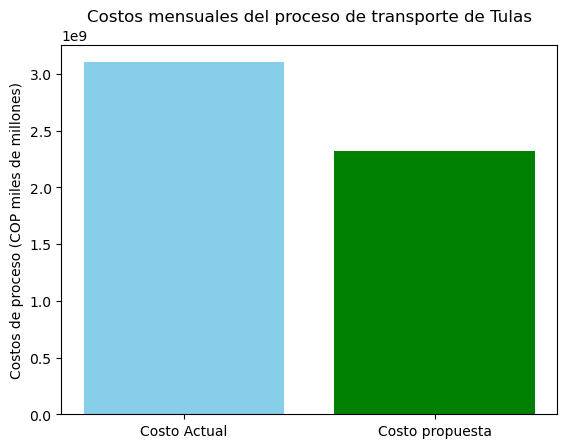

In [14]:
import matplotlib.pyplot as plt

lista_1 = ['Costo Actual', 'Costo propuesta']
lista_2 = [costo_actual,obj]
colores = ['skyblue', 'green']
plt.bar(lista_1, lista_2, color=colores)
plt.ylabel('Costos de proceso (COP miles de millones)')  

plt.title('Costos mensuales del proceso de transporte de Tulas')
plt.show()

In [15]:
envios_car = []
for k in lista_car:
    total = sum(lp.value(x[k,j]) for j in lista_clc)
    envios_car.append(total)

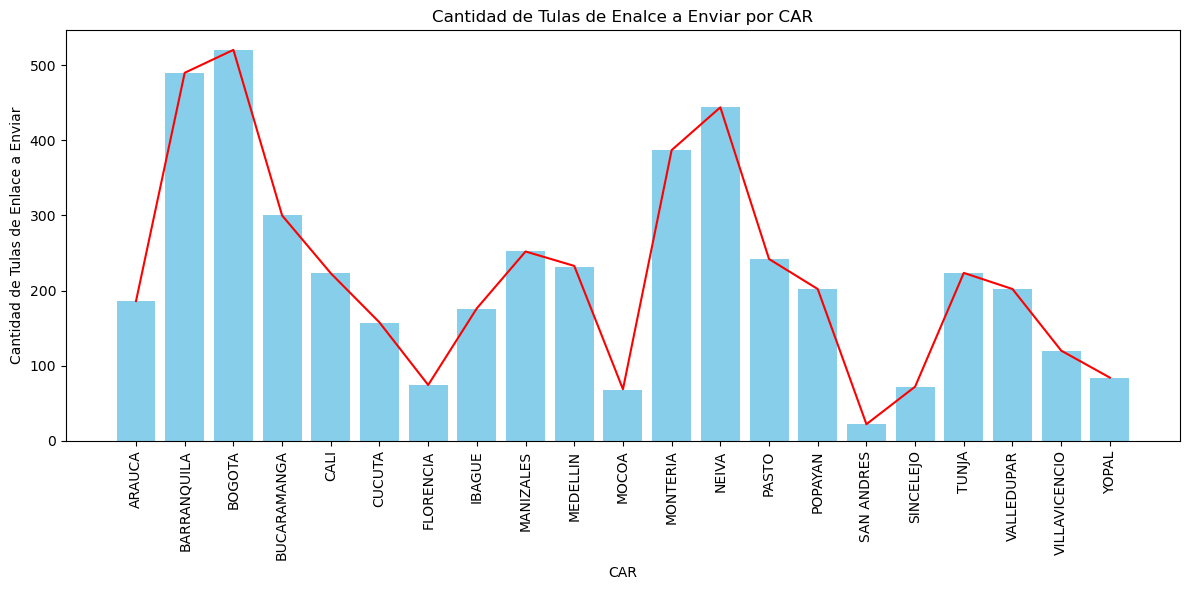

In [17]:
plt.figure(figsize=(12, 6))  
plt.bar(lista_car, envios_car, color='skyblue')
plt.plot(lista_car,demandas_car.values, c="r", label="Demanda CAR")
plt.xlabel('CAR')  
plt.ylabel('Cantidad de Tulas de Enlace a Enviar')  
plt.xticks(rotation=90)  

plt.title('Cantidad de Tulas de Enalce a Enviar por CAR') 

plt.tight_layout()
plt.show()

In [18]:
envios_oficina = []
for i in lista_oficinas:
    total = sum(lp.value(y[i,j]) for j in lista_clc)
    envios_oficina.append(total)

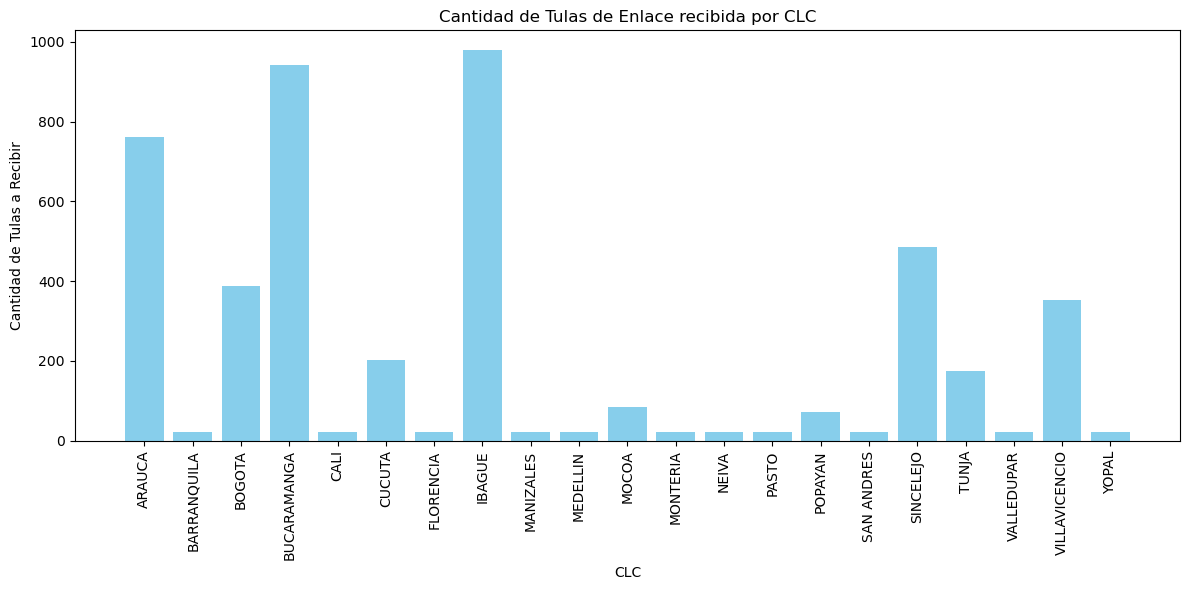

In [19]:
recibo_clc_enlace = []
for j in lista_clc:
    total = sum(lp.value(x[k,j]) for k in lista_car)
    recibo_clc_enlace.append(total)
    
plt.figure(figsize=(12, 6))
plt.bar(lista_clc, recibo_clc_enlace, color='skyblue')
plt.xlabel('CLC')  
plt.ylabel('Cantidad de Tulas a Recibir')  
plt.xticks(rotation=90) 

plt.title('Cantidad de Tulas de Enlace recibida por CLC') 

plt.tight_layout()
plt.show()

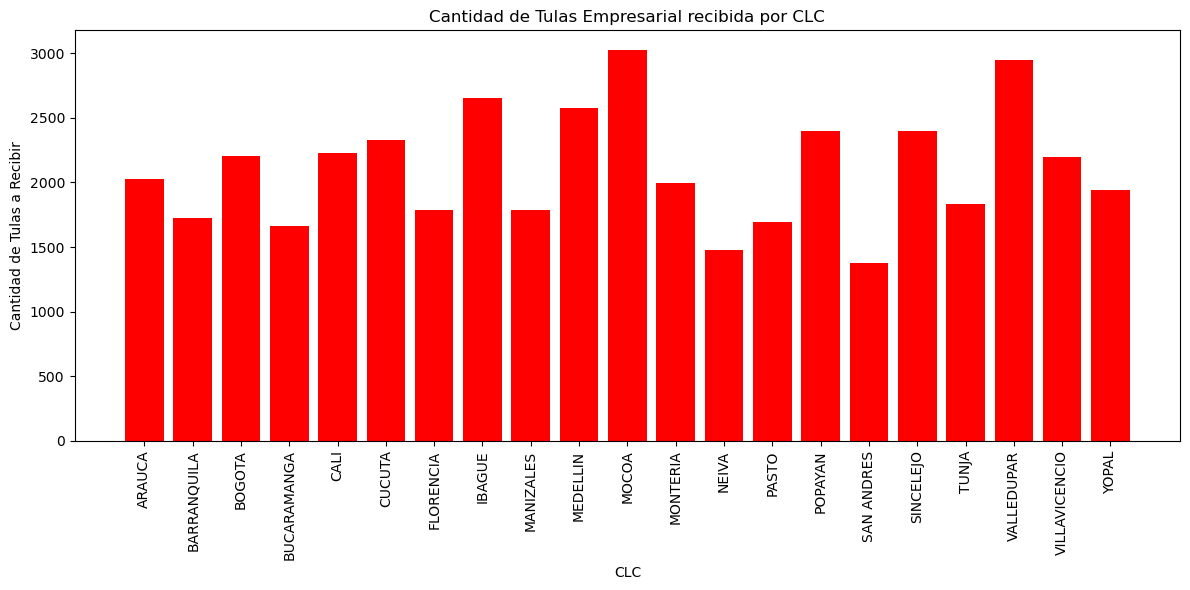

In [20]:
recibo_clc_empresarial = []
for j in lista_clc:
    total = sum(lp.value(y[i,j]) for i in lista_oficinas)
    recibo_clc_empresarial.append(total)
    
plt.figure(figsize=(12, 6))
plt.bar(lista_clc, recibo_clc_empresarial, color='red')
plt.xlabel('CLC')  
plt.ylabel('Cantidad de Tulas a Recibir')  
plt.xticks(rotation=90)  

plt.title('Cantidad de Tulas Empresarial recibida por CLC')  

plt.tight_layout()
plt.show()